# Model testing

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import confinement_mode_classifier as cmc
from datetime import datetime
import time 
import torchvision
import torch
from torch.optim import lr_scheduler
import numpy as np
from tqdm.notebook import tqdm
import torch.nn as nn
%matplotlib widget
from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassROC

Seed set to 42


Device: cuda:0


In [2]:
path = Path(os.getcwd())
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


batch_size = 32
shots = [16769, 18130, 18057]
shots_for_testing = shots


shot_df, test_df, _, _ = cmc.load_and_split_dataframes(path,shots, shots_for_testing, [])


test_dataloader = cmc.get_dloader(test_df, path=path, batch_size=batch_size, shuffle=False, balance_data=False)

In [3]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1', )
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM
pretrained_model = pretrained_model.to(device)

In [4]:

pretrained_model.load_state_dict(torch.load(f'{path}/runs/14-12-2023, 13-18-26 Compairing frozen and unfrozen models/model_fully_trained.pt'))

<All keys matched successfully>

In [5]:
pretrained_model.eval()
pretrained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

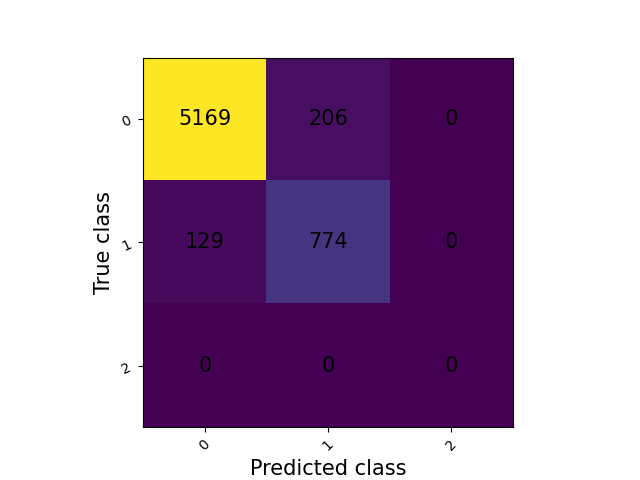

In [6]:

predictions_df_dtest, fig_confusion_matrix_dtest, f1_dtest, precision_dtest, recall_dtest, accuracy_dtest = cmc.test_model(
        pretrained_model, test_dataloader)


In [12]:


for shot in tqdm(shots):
    pred_for_shot = predictions_df_dtest[predictions_df_dtest['shot']==shot]
    softmax_out = torch.nn.functional.softmax(torch.tensor(pred_for_shot[['L_logit','H_logit','ELM_logit']].values), dim=1)

    preds_tensor = torch.tensor(pred_for_shot['prediction'].values.astype(float))
    labels_tensor = torch.tensor(pred_for_shot['label'].values.astype(int))

    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=3)
    confusion_matrix_metric.update(preds_tensor, labels_tensor)
    conf_matrix_fig, conf_matrix_ax = confusion_matrix_metric.plot()
    mcroc = MulticlassROC(num_classes=3, thresholds=64)
    mcroc.update(torch.tensor(pred_for_shot[['L_logit', 'H_logit', 'ELM_logit']].values.astype(float)), labels_tensor)

    #ROC metric
    roc_fig, roc_ax = mcroc.plot(score=True)
    #f1 score
    f1 = F1Score(task="multiclass", num_classes=3)(preds_tensor, labels_tensor)
    #Precision
    precision = MulticlassPrecision(num_classes=3)(preds_tensor, labels_tensor)
    #recall
    recall = MulticlassRecall(num_classes=3)(preds_tensor, labels_tensor)
    #accuracy
    accuracy = len(pred_for_shot[pred_for_shot['prediction']==pred_for_shot['label']])/len(pred_for_shot)
    
    textstr = '\n'.join((
        f'shot {shot}',
        r'threshhold = 0.5:',
        r'f1=%.2f' % (f1.item(), ),
        r'precision=%.2f' % (precision.item(), ),
        r'recall=%.2f' % (recall.item(), ),
        r'accuracy=%.2f' % (accuracy, )))


    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(pred_for_shot['time'],softmax_out[:,1], label='model confidence')
    ax.plot(pred_for_shot['time'],pred_for_shot['label'], lw=3, alpha=.5, label='label')
    ax.set_xlabel('t [ms]')
    ax.set_ylabel('H-mod confidence')
    plt.title(f'shot {shots[1]}')
    ax.legend()
    #a[1] = axs
    #axs.text(0.5, 0.5, "Confusion Matrix", ha='center', va='center', fontsize=12, color='black')

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    roc_ax.text(0.05, 0.3, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', bbox=props)
    

    
    # Save the figures to temporary files
    fig.savefig(f'{path}/data/time_confidence_for_shot_{shot}.png')
    roc_fig.savefig(f'{path}/data/roc_for_shot_{shot}.png')
    conf_matrix_fig.savefig(f'{path}/data/confusion_matrix_for_shot_{shot}.png')

    # Open the saved images using Pillow
    time_confidence_img = Image.open(f'{path}/data/time_confidence_for_shot_{shot}.png')
    roc_img = Image.open(f'{path}/data/roc_for_shot_{shot}.png')
    conf_matrix_img = Image.open(f'{path}/data/confusion_matrix_for_shot_{shot}.png')


    combined_image = Image.new('RGB', (time_confidence_img.width + roc_img.width + conf_matrix_img.width,\
                                        max(time_confidence_img.height, roc_img.height, conf_matrix_img.height)))

    # Paste the saved images into the combined image
    combined_image.paste(time_confidence_img, (0, 0))
    combined_image.paste(roc_img, (time_confidence_img.width, 0))
    combined_image.paste(conf_matrix_img, (time_confidence_img.width+roc_img.width, 0))

    # Save the combined image
    combined_image.save(f'{path}/data/combined_image_for_shot_{shot}.png')

  0%|          | 0/3 [00:00<?, ?it/s]